In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import cv2

磁気リコネクション(CANS+より) \
使用スキーム：HLLD法・MUSCL(minmod)法・ホイン法・CT法

In [2]:
def minmod(x, y):
    return cp.sign(x) * cp.maximum(cp.minimum(cp.abs(x), cp.sign(x) * y), 1e-20)


def get_L_component(rho, u, v, w, By, Bz, p, axis):
    rho_L = rho + 1/2 * minmod(rho - cp.roll(rho, 1, axis=axis), cp.roll(rho, -1, axis=axis) - rho)
    u_L = u + 1/2 * minmod(u - cp.roll(u, 1, axis=axis), cp.roll(u, -1, axis=axis) - u)
    v_L = v + 1/2 * minmod(v - cp.roll(v, 1, axis=axis), cp.roll(v, -1, axis=axis) - v)
    w_L = w + 1/2 * minmod(w - cp.roll(w, 1, axis=axis), cp.roll(w, -1, axis=axis) - w)
    By_L = By + 1/2 * minmod(By - cp.roll(By, 1, axis=axis), cp.roll(By, -1, axis=axis) - By)
    Bz_L = Bz + 1/2 * minmod(Bz - cp.roll(Bz, 1, axis=axis), cp.roll(Bz, -1, axis=axis) - Bz)
    p_L = p + 1/2 * minmod(p - cp.roll(p, 1, axis=axis), cp.roll(p, -1, axis=axis) - p)

    return rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L


def get_R_component(rho, u, v, w, By, Bz, p, axis):
    rho_R = cp.roll(rho, -1, axis=axis) - 1/2 * minmod(cp.roll(rho, -1, axis=axis) - rho, cp.roll(rho, -2, axis=axis) - cp.roll(rho, -1, axis=axis))
    u_R = cp.roll(u, -1, axis=axis) - 1/2 * minmod(cp.roll(u, -1, axis=axis) - u, cp.roll(u, -2, axis=axis) - cp.roll(u, -1, axis=axis))
    v_R = cp.roll(v, -1, axis=axis) - 1/2 * minmod(cp.roll(v, -1, axis=axis) - v, cp.roll(v, -2, axis=axis) - cp.roll(v, -1, axis=axis))
    w_R = cp.roll(w, -1, axis=axis) - 1/2 * minmod(cp.roll(w, -1, axis=axis) - w, cp.roll(w, -2, axis=axis) - cp.roll(w, -1, axis=axis))
    By_R = cp.roll(By, -1, axis=axis) - 1/2 * minmod(cp.roll(By, -1, axis=axis) - By, cp.roll(By, -2, axis=axis) - cp.roll(By, -1, axis=axis))
    Bz_R = cp.roll(Bz, -1, axis=axis) - 1/2 * minmod(cp.roll(Bz, -1, axis=axis) - Bz, cp.roll(Bz, -2, axis=axis) - cp.roll(Bz, -1, axis=axis))
    p_R = cp.roll(p, -1, axis=axis) - 1/2 * minmod(cp.roll(p, -1, axis=axis) - p, cp.roll(p, -2, axis=axis) - cp.roll(p, -1, axis=axis))
    
    return rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT1, S, SM):
    rho1 = rho * (S - u) / (S - SM + 1e-20)
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    e1 = ((S - u) * e - pT * u + pT1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx + v1*By1 + w1*Bz1))) / (S - SM + 1e-20)
    
    return rho1, u1, v1, w1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    v2 = (cp.sqrt(rho1_L) * v1_L + cp.sqrt(rho1_R) * v1_R + (By1_R - By1_L) * cp.sign(Bx)) / (cp.sqrt(rho1_L) + cp.sqrt(rho1_R))
    w2 = (cp.sqrt(rho1_L) * w1_L + cp.sqrt(rho1_R) * w1_R + (Bz1_R - Bz1_L) * cp.sign(Bx)) / (cp.sqrt(rho1_L) + cp.sqrt(rho1_R))
    By2 = (cp.sqrt(rho1_L) * By1_R + cp.sqrt(rho1_R) * By1_L + cp.sqrt(rho1_L * rho1_R) * (v1_R - v1_L) * cp.sign(Bx)) / (cp.sqrt(rho1_L) + cp.sqrt(rho1_R))
    Bz2 = (cp.sqrt(rho1_L) * Bz1_R + cp.sqrt(rho1_R) * Bz1_L + cp.sqrt(rho1_L * rho1_R) * (w1_R - w1_L) * cp.sign(Bx)) / (cp.sqrt(rho1_L) + cp.sqrt(rho1_R))
    e2_L = e1_L - cp.sqrt(rho1_L) * ((u1_L * Bx + v1_L * By1_L + w1_L * Bz1_L) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * cp.sign(Bx)
    e2_R = e1_R + cp.sqrt(rho1_R) * ((u1_R * Bx + v1_R * By1_R + w1_R * Bz1_R) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * cp.sign(Bx)

    return u2, v2, w2, By2, Bz2, e2_L, e2_R


def get_flux_F(rho, u, v, w, Bx, By, Bz, e, pT, eta, dx, dy, F):
    current_y = -(cp.roll(Bz, -1, axis=0) - cp.roll(Bz, 1, axis=0)) / (2.0 * dx)
    current_z = (cp.roll(By, -1, axis=0) - cp.roll(By, 1, axis=0)) / (2.0 * dx) \
              - (cp.roll(Bx, -1, axis=1) - cp.roll(Bx, 1, axis=1)) / (2.0 * dy)
    F[0, :, :] = rho * u
    F[1, :, :] = rho * u**2 + pT - Bx**2
    F[2, :, :] = rho * u * v - Bx * By
    F[3, :, :] = rho * u * w - Bx * Bz
    F[4, :, :] = 0.0
    F[5, :, :] = u * By - v * Bx - eta * current_z 
    F[6, :, :] = u * Bz - w * Bx + eta * current_y
    F[7, :, :] = (e + pT) * u - Bx * (Bx * u + By * v + Bz * w) + eta * (current_y * Bz - current_z * By)
    return F


def get_flux_G(rho, u, v, w, Bx, By, Bz, e, pT, eta, dx, dy, F):
    # currentの計算以外は同じ。ここは特にバグに注意。
    # BxにBy・ByにBz・BzにBxが入っている。
    # フラックスのところの符号も違う。
    current_x = (cp.roll(By, -1, axis=1) - cp.roll(By, 1, axis=1)) / (2.0 * dy)
    current_z = (cp.roll(Bx, -1, axis=0) - cp.roll(Bx, 1, axis=0)) / (2.0 * dx) \
              - (cp.roll(Bz, -1, axis=1) - cp.roll(Bz, 1, axis=1)) / (2.0 * dy)
    F[0, :, :] = rho * u
    F[1, :, :] = rho * u**2 + pT - Bx**2
    F[2, :, :] = rho * u * v - Bx * By
    F[3, :, :] = rho * u * w - Bx * Bz
    F[4, :, :] = 0.0
    F[5, :, :] = u * By - v * Bx - eta * current_x 
    F[6, :, :] = u * Bz - w * Bx + eta * current_z
    F[7, :, :] = (e + pT) * u - Bx * (Bx * u + By * v + Bz * w) + eta * (current_z * Bz - current_x * By)
    return F


def get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, eta, dx, dy, F, axis):

    p = (gamma - 1.0) * (e - rho * 0.5 * (u**2 + v**2 + w**2) - 0.5 * (Bx**2 + By**2 + Bz**2))
    # 半整数格子点上のものを使わないといけない。1次元だと関係なかったけど。
    Bx_half = 0.5 * (Bx + cp.roll(Bx, -1, axis=axis))
    eta_half = 0.5 * (eta + cp.roll(eta, -1, axis=axis))
    rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L = get_L_component(rho, u, v, w, By, Bz, p, axis)
    rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R = get_R_component(rho, u, v, w, By, Bz, p, axis)
    pT_L = p_L + 0.5 * (Bx_half**2 + By_L**2 + Bz_L**2)
    pT_R = p_R + 0.5 * (Bx_half**2 + By_R**2 + Bz_R**2)
    e_L = p_L / (gamma - 1.0) + rho_L * 0.5 * (u_L**2 + v_L**2 + w_L**2) + 0.5 * (Bx_half**2 + By_L**2 + Bz_L**2)
    e_R = p_R / (gamma - 1.0) + rho_R * 0.5 * (u_R**2 + v_R**2 + w_R**2) + 0.5 * (Bx_half**2 + By_R**2 + Bz_R**2)
    cs_L = cp.sqrt(gamma * p_L / rho_L)
    cs_R = cp.sqrt(gamma * p_R / rho_R)
    ca_L = cp.sqrt((Bx_half**2 + By_L**2 + Bz_L**2) / rho_L)
    ca_R = cp.sqrt((Bx_half**2 + By_R**2 + Bz_R**2) / rho_R)
    va_L = cp.sqrt(Bx_half**2 / rho_L)
    va_R = cp.sqrt(Bx_half**2 / rho_R)
    cf_L = cp.sqrt(0.5 * (cs_L**2 + ca_L**2 + cp.sqrt((cs_L**2 + ca_L**2)**2 - 4.0 * cs_L**2 * va_L**2)))
    cf_R = cp.sqrt(0.5 * (cs_R**2 + ca_R**2 + cp.sqrt((cs_R**2 + ca_R**2)**2 - 4.0 * cs_R**2 * va_R**2)))
    S_L = cp.minimum(u_L - cf_L, u_R - cf_R)
    S_R = cp.maximum(u_L + cf_L, u_R + cf_R)

    SM = ((S_R - u_R) * rho_R * u_R - (S_L - u_L) * rho_L * u_L - pT_R + pT_L) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L + 1e-20)
    pT1 = ((S_R - u_R) * rho_R * pT_L - (S_L - u_L) * rho_L * pT_R + rho_L * rho_R * (S_R - u_R) * (S_L - u_L) * (u_R - u_L)) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L + 1e-20)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L, u1_L, v1_L, w1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx_half, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    rho1_R, u1_R, v1_R, w1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx_half, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - cp.sqrt(Bx_half**2 / rho1_L)
    S1_R = SM + cp.sqrt(Bx_half**2 / rho1_R)

    u2, v2, w2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx_half, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2_L = pT1
    pT2_R = pT1
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = cp.zeros(F.shape)
    F1_L = cp.zeros(F.shape)
    F2_L = cp.zeros(F.shape)
    F_R = cp.zeros(F.shape)
    F1_R = cp.zeros(F.shape)
    F2_R = cp.zeros(F.shape)
    # eta*currentによって対称性が消えたので臨時対応
    if axis == 0:
        F_L = get_flux_F(rho_L, u_L, v_L, w_L, Bx_half, By_L, Bz_L, e_L, pT_L, eta_half, dx, dy, F_L)
        F1_L = get_flux_F(rho1_L, u1_L, v1_L, w1_L, Bx_half, By1_L, Bz1_L, e1_L, pT1_L, eta_half, dx, dy, F1_L)
        F2_L = get_flux_F(rho2_L, u2, v2, w2, Bx_half, By2, Bz2, e2_L, pT2_L, eta_half, dx, dy, F2_L)
        F_R = get_flux_F(rho_R, u_R, v_R, w_R, Bx_half, By_R, Bz_R, e_R, pT_R, eta_half, dx, dy, F_R)
        F1_R = get_flux_F(rho1_R, u1_R, v1_R, w1_R, Bx_half, By1_R, Bz1_R, e1_R, pT1_R, eta_half, dx, dy, F1_R)
        F2_R = get_flux_F(rho2_R, u2, v2, w2, Bx_half, By2, Bz2, e2_R, pT2_R, eta_half, dx, dy, F2_R)
    elif axis == 1:
        F_L = get_flux_G(rho_L, u_L, v_L, w_L, Bx_half, By_L, Bz_L, e_L, pT_L, eta_half, dx, dy, F_L)
        F1_L = get_flux_G(rho1_L, u1_L, v1_L, w1_L, Bx_half, By1_L, Bz1_L, e1_L, pT1_L, eta_half, dx, dy, F1_L)
        F2_L = get_flux_G(rho2_L, u2, v2, w2, Bx_half, By2, Bz2, e2_L, pT2_L, eta_half, dx, dy, F2_L)
        F_R = get_flux_G(rho_R, u_R, v_R, w_R, Bx_half, By_R, Bz_R, e_R, pT_R, eta_half, dx, dy, F_R)
        F1_R = get_flux_G(rho1_R, u1_R, v1_R, w1_R, Bx_half, By1_R, Bz1_R, e1_R, pT1_R, eta_half, dx, dy, F1_R)
        F2_R = get_flux_G(rho2_R, u2, v2, w2, Bx_half, By2, Bz2, e2_R, pT2_R, eta_half, dx, dy, F2_R)
    else:
        print("Set axis = 0 or 1")

    F = F_L * (S_L > 0.0) + F1_L * ((S_L <= 0.0) & (0.0 < S1_L)) + F2_L * ((S1_L <= 0.0) & (0.0 < SM)) \
      + F_R * (S_R <= 0.0) + F1_R * ((S1_R <= 0.0) & (0.0 < S_R)) + F2_R * ((SM <= 0.0) & (0.0 < S1_R))

    return F 


def divB_cleaner_CT(Bx_old, By_old, Ez_F, Ez_G, dx, dy, dt, U):
    
    Ez = 0.25 * (Ez_G + cp.roll(Ez_G, -1, axis=0) + Ez_F + cp.roll(Ez_F, -1, axis=1))
    U[4, :, :] = Bx_old - dt/dy * (Ez - cp.roll(Ez, 1, axis=1))
    U[5, :, :] = By_old + dt/dx * (Ez - cp.roll(Ez, 1, axis=0))

    return U

In [35]:
def boundary_symmetric_x(U):
    # rho, v, Bz, e
    U[[0, 2, 6, 7], 0, :] = U[[0, 2, 6, 7], 3, :]
    U[[0, 2, 6, 7], 1, :] = U[[0, 2, 6, 7], 3, :]
    U[[0, 2, 6, 7], 2, :] = U[[0, 2, 6, 7], 3, :]
    U[[0, 2, 6, 7], -1, :] = U[[0, 2, 6, 7], -4, :]
    U[[0, 2, 6, 7], -2, :] = U[[0, 2, 6, 7], -4, :]
    U[[0, 2, 6, 7], -3, :] = U[[0, 2, 6, 7], -4, :]

    # Bxは半整数格子点上にあるので注意
    U[4, 0, :] = U[4, 2, :]
    U[4, 1, :] = U[4, 2, :]
    U[4, -1, :] = U[4, -4, :]
    U[4, -2, :] = U[4, -4, :]
    U[4, -3, :] = U[4, -4, :]

    # u, w, By
    U[[1, 3, 5], 0, :] = 0.0
    U[[1, 3, 5], 1, :] = 0.0
    U[[1, 3, 5], 2, :] = 0.0
    U[[1, 3, 5], -1, :] = 0.0
    U[[1, 3, 5], -2, :] = 0.0
    U[[1, 3, 5], -3, :] = 0.0

    return U


def boundary_free_y(U):
    # rho, Bx, Bz, eのy方向微分=0
    U[[0, 1, 2, 3, 4, 6, 7], :, 0] = U[[0, 1, 2, 3, 4, 6, 7], :, 3]
    U[[0, 1, 2, 3, 4, 6, 7], :, 1] = U[[0, 1, 2, 3, 4, 6, 7], :, 3]
    U[[0, 1, 2, 3, 4, 6, 7], :, 2] = U[[0, 1, 2, 3, 4, 6, 7], :, 3]
    U[[0, 1, 2, 3, 4, 6, 7], :, -1] = U[[0, 1, 2, 3, 4, 6, 7], :, -4]
    U[[0, 1, 2, 3, 4, 6, 7], :, -2] = U[[0, 1, 2, 3, 4, 6, 7], :, -4]
    U[[0, 1, 2, 3, 4, 6, 7], :, -3] = U[[0, 1, 2, 3, 4, 6, 7], :, -4]

    # Byは半整数格子点上にあるので注意
    U[5, :, 0] = U[5, :, 2]
    U[5, :, 1] = U[5, :, 2]
    U[5, :, -1] = U[5, :, -4]
    U[5, :, -2] = U[5, :, -4]
    U[5, :, -3] = U[5, :, -4]
    
    return U

In [45]:
gamma = 5.0/3.0
B0 = 1.0
rho0 = 1.0
sheat_thickness = 1.0
p0 = B0**2 / 2.0 #カレントシート中央での圧力
beta_upstream = 0.2
VA = B0 / cp.sqrt(rho0)
x_max = 100.0
y_max = 10.0
dx = sheat_thickness / 4.0
dy = dx
nx = int(x_max / dx)
ny = int(2.0 * y_max / dy)
dt = 0.0
CFL = 0.4
x = cp.arange(0.0, x_max, dx)
y = cp.arange(-y_max, y_max, dy)
X, Y = cp.meshgrid(x, y)

U = cp.zeros([8, x.shape[0], y.shape[0]])
rho_init = rho0 * (beta_upstream + cp.cosh(Y / sheat_thickness)**(-2)).T
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = B0 * cp.tanh(Y / sheat_thickness).T
By_init = 0.0
Bz_init = 0.0
# 擾乱を加える
position_x = 0.3 * x_max
p_init = p0 * (beta_upstream + cp.cosh(Y / sheat_thickness)**(-2)).T
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

eta0 = 1.0 / 1000.0
eta1 = 1.0 / 200.0
eta = (eta0 + (eta1 - eta0) * cp.cosh(cp.sqrt((X - position_x)**2 + Y**2))**(-2)).T
S = sheat_thickness * VA / eta0

F = cp.zeros(U.shape)
F_bar = cp.zeros(F.shape)
G = cp.zeros(U.shape)
G_bar = cp.zeros(G.shape)

In [46]:
max_step = 100000
time = 0.0
calculation_time = 200.0
log_filename = "log_mr.txt"
np.save(f"results_mr/U_{0}.npy", U)
with open(log_filename, 'w') as log_file:
    log_file.write(f"{0},{time:.5f},{dt:.5f}\n")

for t in range(1, max_step+1):
    if np.isnan(time):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed!")
        break

    if (t % 100 == 0):
        print(f"{t} step done... : time = {time:.5f}, dt = {dt:.5f}")
        np.save(f"results_mr/U_{t}.npy", U)
        with open(log_filename, 'a') as log_file:
            log_file.write(f"{t},{time:.5f},{dt:.5f}\n")

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break

    
    U_bar = U.copy()
    Bx_old = U[4, :, :].copy()
    By_old = U[5, :, :].copy()

    rho = U[0, :, :]
    u = U[1, :, :] / rho
    v = U[2, :, :] / rho
    w = U[3, :, :] / rho
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma - 1.0) * (e - 0.5 * rho * (u**2+v**2+w**2) - 0.5 * (Bx**2+By**2+Bz**2))

    Bx = 0.5 * (Bx + np.roll(Bx, 1, axis=0))
    By = 0.5 * (By + np.roll(By, 1, axis=1))

    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, eta, dx, dy, F, axis=0)
    G = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, eta, dx, dy, G, axis=1)
    G_tmp = G.copy()
    G[1, :, :] = G_tmp[3, :, :]
    G[2, :, :] = G_tmp[1, :, :]
    G[3, :, :] = G_tmp[2, :, :]
    G[4, :, :] = G_tmp[6, :, :]
    G[5, :, :] = G_tmp[4, :, :]
    G[6, :, :] = G_tmp[5, :, :]

    cs = np.sqrt(gamma * p / rho)
    ca = np.sqrt((Bx**2 + By**2 + Bz**2) / rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2 + ca**2)) / dx + (np.abs(v) + np.sqrt(cs**2 + ca**2)) / dy))
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1)) - dt/dy * (G - np.roll(G, 1, axis=2))
    # x方向対称境界条件・y方向反射端境界(導体壁？)
    U_bar = boundary_symmetric_x(U_bar)
    U_bar = boundary_free_y(U_bar)
    
    Ez_F = F[5, :, :] * (-1)
    Ez_G = G[4, :, :]
    U_bar = divB_cleaner_CT(Bx_old, By_old, Ez_F, Ez_G, dx, dy, dt, U_bar)
    # x方向対称境界条件・y方向反射端境界(導体壁？)
    U_bar = boundary_symmetric_x(U_bar)
    U_bar = boundary_free_y(U_bar)

    rho = U_bar[0, :, :]
    u = U_bar[1, :, :] / rho
    v = U_bar[2, :, :] / rho
    w = U_bar[3, :, :] / rho
    Bx = U_bar[4, :, :]
    By = U_bar[5, :, :]
    Bz = U_bar[6, :, :]
    e = U_bar[7, :, :]
    p = (gamma - 1.0) * (e - 0.5 * rho * (u**2 + v**2 + w**2) - 0.5 * (Bx**2 + By**2 + Bz**2))
    
    Bx = 0.5 * (Bx + np.roll(Bx, 1, axis=0))
    By = 0.5 * (By + np.roll(By, 1, axis=1))

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, eta, dx, dy, F_bar, axis=0)
    G_bar = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, eta, dx, dy, G_bar, axis=1)
    G_tmp = G_bar.copy()
    G_bar[1, :, :] = G_tmp[3, :, :]
    G_bar[2, :, :] = G_tmp[1, :, :]
    G_bar[3, :, :] = G_tmp[2, :, :]
    G_bar[4, :, :] = G_tmp[6, :, :]
    G_bar[5, :, :] = G_tmp[4, :, :]
    G_bar[6, :, :] = G_tmp[5, :, :]

    F = 0.5 * (F + F_bar)
    G = 0.5 * (G + G_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1)) - dt/dy * (G - np.roll(G, 1, axis=2))
    # x方向対称境界条件・y方向反射端境界(導体壁？)
    U = boundary_symmetric_x(U)
    U = boundary_free_y(U)
    
    Ez_F = F[5, :, :] * (-1)
    Ez_G = G[4, :, :]
    U = divB_cleaner_CT(Bx_old, By_old, Ez_F, Ez_G, dx, dy, dt, U)
    # x方向対称境界条件・y方向反射端境界(導体壁？)
    U = boundary_symmetric_x(U)
    U = boundary_free_y(U)

    time += dt

100 step done... : time = 2.04949, dt = 0.02070
200 step done... : time = 4.11647, dt = 0.02067
300 step done... : time = 6.18510, dt = 0.02070
400 step done... : time = 8.25510, dt = 0.02070
500 step done... : time = 10.32491, dt = 0.02070
600 step done... : time = 12.39434, dt = 0.02069
700 step done... : time = 14.46335, dt = 0.02069
800 step done... : time = 16.53180, dt = 0.02068
900 step done... : time = 18.59940, dt = 0.02067
1000 step done... : time = 20.66597, dt = 0.02066
1100 step done... : time = 22.73116, dt = 0.02065
1200 step done... : time = 24.79482, dt = 0.02063
1300 step done... : time = 26.85649, dt = 0.02061
1400 step done... : time = 28.91611, dt = 0.02059
1500 step done... : time = 30.97355, dt = 0.02056
1600 step done... : time = 33.02843, dt = 0.02054
1700 step done... : time = 35.08107, dt = 0.02052
1800 step done... : time = 37.13160, dt = 0.02049
1900 step done... : time = 39.17983, dt = 0.02047
2000 step done... : time = 41.22531, dt = 0.02044
2100 step don

動画作成


In [47]:
gamma = 5.0/3.0
B0 = 1.0
rho0 = 1.0
sheat_thickness = 1.0
p0 = B0**2 / 2.0 #カレントシート中央での圧力
beta_upstream = 0.2
VA = B0 / np.sqrt(rho0)
x_max = 100.0
y_max = 10.0
dx = sheat_thickness / 4.0
dy = dx
nx = int(x_max / dx)
ny = int(2.0 * y_max / dy)
dt = 0.0
CFL = 0.4
x = np.arange(0.0, x_max, dx)
y = np.arange(-y_max, y_max, dy)
X, Y = np.meshgrid(x, y)

U = np.zeros([8, x.shape[0], y.shape[0]])
rho_init = rho0 * (beta_upstream + np.cosh(Y / sheat_thickness)**(-2)).T
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = B0 * np.tanh(Y / sheat_thickness).T
By_init = 0.0
Bz_init = 0.0
# 擾乱を加える
position_x = 0.1 * x_max
p_init = p0 * (beta_upstream + np.cosh(Y / sheat_thickness)**(-2)).T
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

eta0 = 1.0 / 1000.0
eta1 = 1.0 / 60.0
eta = (eta0 + (eta1 - eta0) * np.cosh(np.sqrt((X - position_x)**2 + Y**2))**(-2)).T
S = sheat_thickness * VA / eta0

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)
G = np.zeros(U.shape)
G_bar = np.zeros(G.shape)

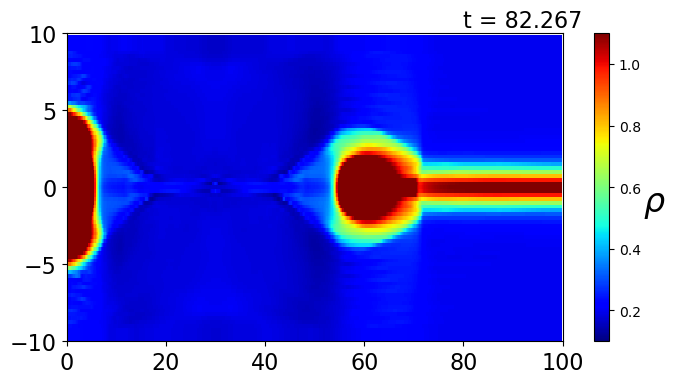

In [44]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

log = np.loadtxt("log_mr.txt", delimiter=',')
total_steps = int(log[-1][0])
interval = 100
for step in range(0, total_steps+interval, interval):
    ax1.clear()

    U = np.load(f"results_mr/U_{step}.npy")
    rho = U[0, :, :]
    u = U[1, :, :] / rho 
    v = U[2, :, :] / rho 
    w = U[3, :, :] / rho 
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
    pT = p + magnetic_pressure

    contour = ax1.pcolormesh(X, Y, (rho).T, vmin=0.1, vmax=1.1, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax1)
        cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)
    quiver_interval = 5
    #ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
    #        u[::quiver_interval, ::quiver_interval].T, v[::quiver_interval, ::quiver_interval].T,
    #        scale=5.0, color='white')

    ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
    ax1.tick_params(labelsize=16)
    ax1.set_xlim(0.0, x_max+1e-10)
    ax1.set_ylim(-y_max, y_max+1e-10)

    fig.savefig(f"pictures_mr/{step}.png", dpi=200)


filename = "mr_rho1.mp4"
img = cv2.imread(f'./pictures_mr/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps+interval, interval):
    img = cv2.imread(f'./pictures_mr/{step}.png')
    video.write(img)
video.release()

(-10.0, 10.0000000001)

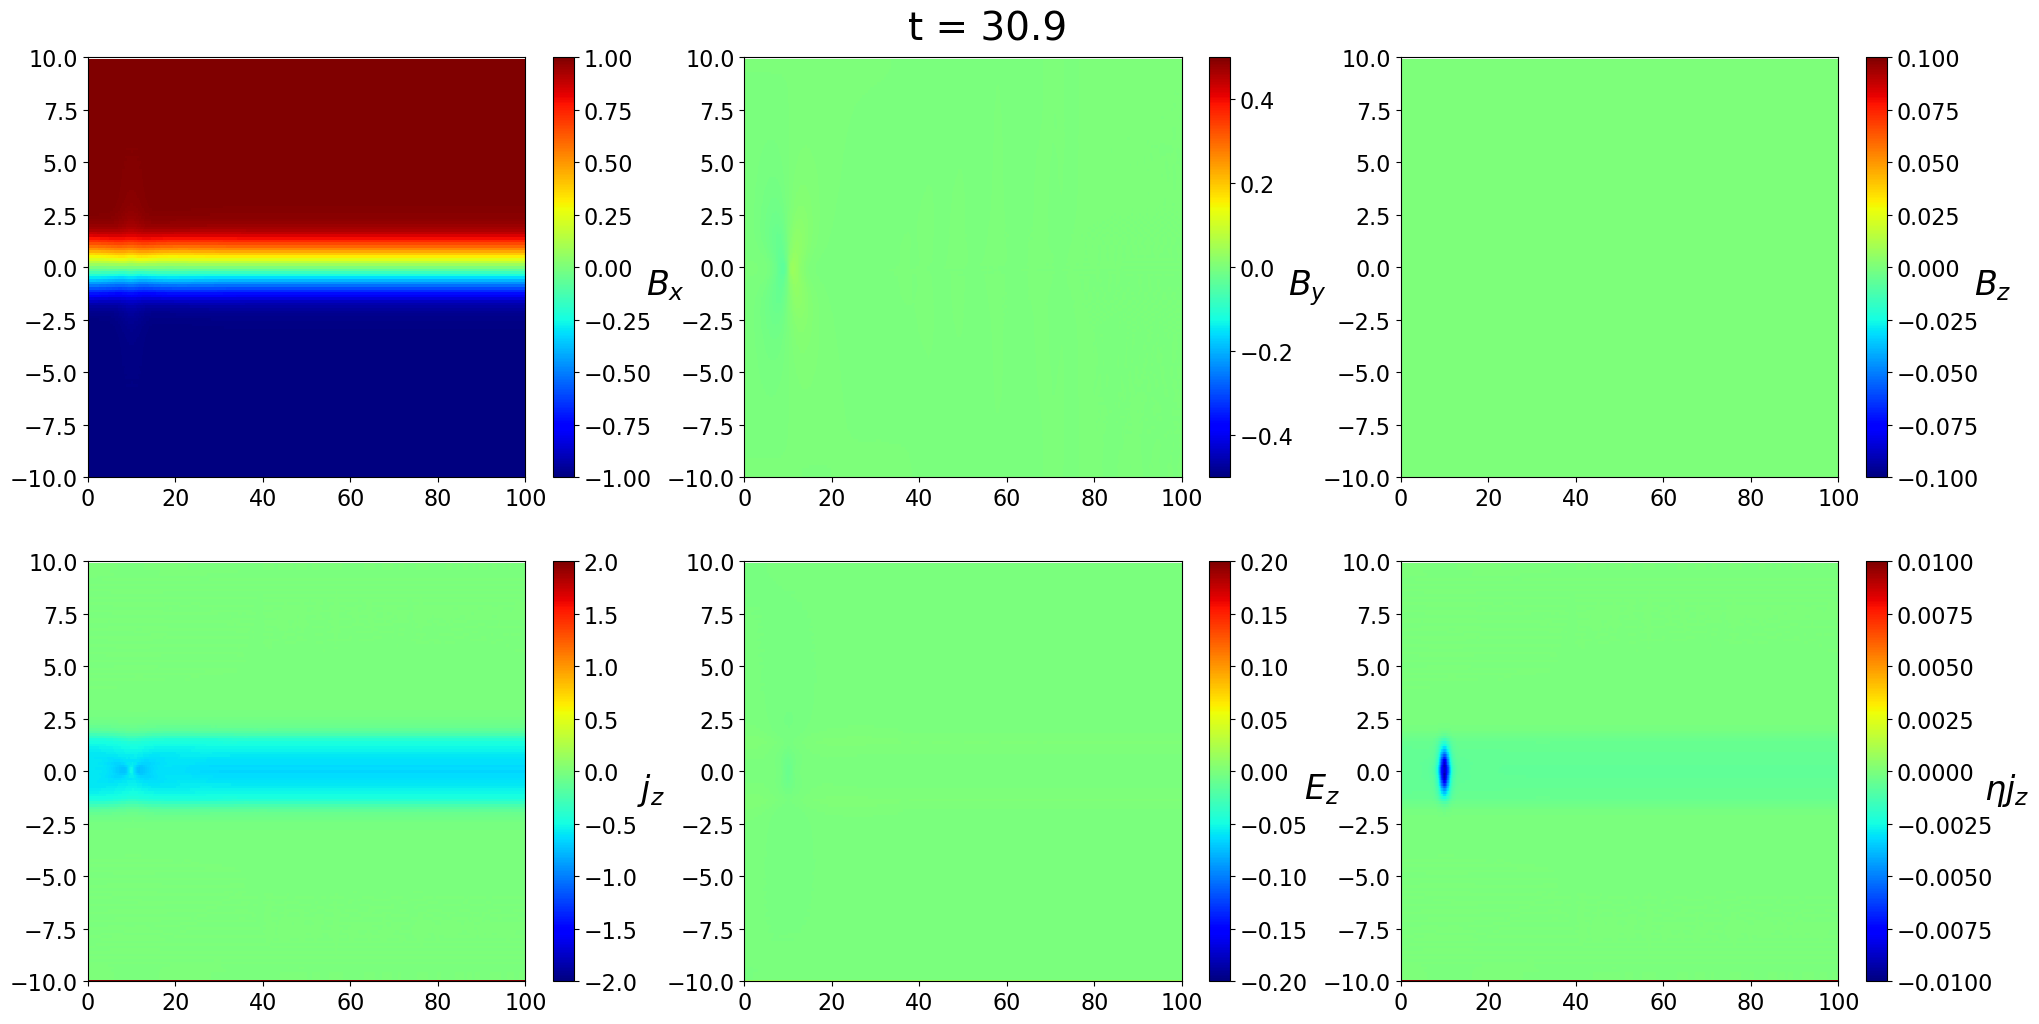

In [41]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

log = np.loadtxt("log_mr.txt", delimiter=',')
step = 3000

U = np.load(f"results_mr/U_{step}.npy")
rho = U[0, :, :]
u = U[1, :, :] / rho 
v = U[2, :, :] / rho 
w = U[3, :, :] / rho 
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
pT = p + magnetic_pressure
current_z = (By - np.roll(By, 1, axis=0)) / dx - (Bx - np.roll(Bx, 1, axis=1)) / dy
Ez = -(u * By - v * Bx) + eta * current_z

contour = ax1.pcolormesh(X, Y, (Bx).T, vmin=-1.0, vmax=1.0, cmap='jet')
cbar = plt.colorbar(contour, ax=ax1)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r"$B_x$", fontsize=24, rotation=0, labelpad=10)

contour = ax2.pcolormesh(X, Y, (By).T, vmin=-0.5, vmax=0.5, cmap='jet')
cbar = plt.colorbar(contour, ax=ax2)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r"$B_y$", fontsize=24, rotation=0, labelpad=10)

contour = ax3.pcolormesh(X, Y, (Bz).T, cmap='jet')
cbar = plt.colorbar(contour, ax=ax3)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r"$B_z$", fontsize=24, rotation=0, labelpad=10)

contour = ax4.pcolormesh(X, Y, (current_z).T, vmin=-2.0, vmax=2.0, cmap='jet')
cbar = plt.colorbar(contour, ax=ax4)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r"$j_z$", fontsize=24, rotation=0, labelpad=10)

contour = ax5.pcolormesh(X, Y, (Ez).T, vmin=-0.2, vmax=0.2, cmap='jet')
cbar = plt.colorbar(contour, ax=ax5)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r"$E_z$", fontsize=24, rotation=0, labelpad=10)

contour = ax6.pcolormesh(X, Y, (eta * current_z).T, vmin=-0.01, vmax=0.01, cmap='jet')
cbar = plt.colorbar(contour, ax=ax6)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r"$\eta j_z$", fontsize=24, rotation=0, labelpad=10)


plt.suptitle(f"t = {log[int(step/100)][1]:.1f}", y=0.92, fontsize=28)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.set_xlim(0.0, x_max+1e-10)
ax2.set_xlim(0.0, x_max+1e-10)
ax3.set_xlim(0.0, x_max+1e-10)
ax4.set_xlim(0.0, x_max+1e-10)
ax5.set_xlim(0.0, x_max+1e-10)
ax6.set_xlim(0.0, x_max+1e-10)
ax1.set_ylim(-y_max, y_max+1e-10)
ax2.set_ylim(-y_max, y_max+1e-10)
ax3.set_ylim(-y_max, y_max+1e-10)
ax4.set_ylim(-y_max, y_max+1e-10)
ax5.set_ylim(-y_max, y_max+1e-10)
ax6.set_ylim(-y_max, y_max+1e-10)

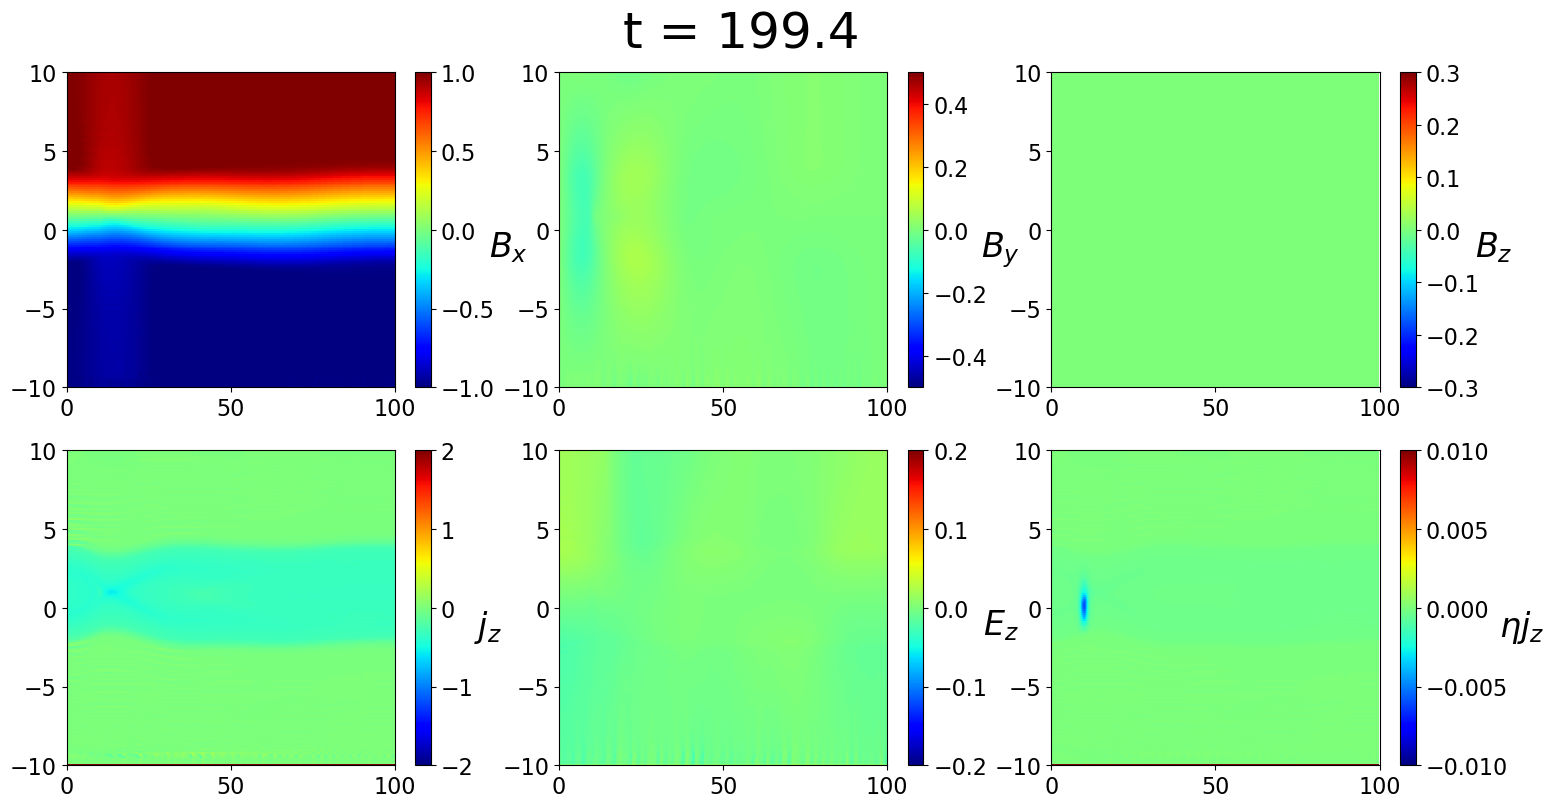

In [42]:
fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

log = np.loadtxt("log_mr.txt", delimiter=',')
total_steps = int(log[-1][0])
interval = 100
for step in range(0, total_steps+interval, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    U = np.load(f"results_mr/U_{step}.npy")
    rho = U[0, :, :]
    u = U[1, :, :] / rho 
    v = U[2, :, :] / rho 
    w = U[3, :, :] / rho 
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
    pT = p + magnetic_pressure
    current_z = (By - np.roll(By, 1, axis=0)) / dx - (Bx - np.roll(Bx, 1, axis=1)) / dy
    Ez = -(u * By - v * Bx) + eta * current_z

    contour = ax1.pcolormesh(X, Y, (Bx).T, vmin=-1.0, vmax=1.0, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax1)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$B_x$", fontsize=24, rotation=0, labelpad=10)

    contour = ax2.pcolormesh(X, Y, (By).T, vmin=-0.5, vmax=0.5, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax2)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$B_y$", fontsize=24, rotation=0, labelpad=10)

    contour = ax3.pcolormesh(X, Y, (Bz).T, vmin=-0.3, vmax=0.3, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax3)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$B_z$", fontsize=24, rotation=0, labelpad=10)

    contour = ax4.pcolormesh(X, Y, (current_z).T, vmin=-2.0, vmax=2.0, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax4)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$j_z$", fontsize=24, rotation=0, labelpad=10)

    contour = ax5.pcolormesh(X, Y, (Ez).T, vmin=-0.2, vmax=0.2, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax5)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$E_z$", fontsize=24, rotation=0, labelpad=10)

    contour = ax6.pcolormesh(X, Y, (eta * current_z).T, vmin=-0.01, vmax=0.01, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax6)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$\eta j_z$", fontsize=24, rotation=0, labelpad=10)

    plt.suptitle(f"t = {log[int(step/100)][1]:.1f}", y=0.95, fontsize=36)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.set_xlim(0.0, x_max+1e-10)
    ax2.set_xlim(0.0, x_max+1e-10)
    ax3.set_xlim(0.0, x_max+1e-10)
    ax4.set_xlim(0.0, x_max+1e-10)
    ax5.set_xlim(0.0, x_max+1e-10)
    ax6.set_xlim(0.0, x_max+1e-10)
    ax1.set_ylim(-y_max, y_max+1e-10)
    ax2.set_ylim(-y_max, y_max+1e-10)
    ax3.set_ylim(-y_max, y_max+1e-10)
    ax4.set_ylim(-y_max, y_max+1e-10)
    ax5.set_ylim(-y_max, y_max+1e-10)
    ax6.set_ylim(-y_max, y_max+1e-10)

    fig.savefig(f"pictures_mr/{step}.png", dpi=200)


filename = "mr_fields1.mp4"
img = cv2.imread(f'./pictures_mr/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps+interval, interval):
    img = cv2.imread(f'./pictures_mr/{step}.png')
    video.write(img)
video.release()

---
MEMO

In [35]:
gamma = 5.0/3.0
B0 = 1.0
rho0 = 1.0
sheat_thickness = 1.0
p0 = B0**2 / 2.0 #カレントシート中央での圧力
beta_upstream = 0.5
VA = B0 / np.sqrt(rho0)
x_max = 75.0
y_max = 20.0
dx = sheat_thickness / 16.0
dy = dx
nx = int(x_max / dx)
ny = int(2.0 * y_max / dy)
dt = 0.0
CFL = 0.4
x = np.arange(0.0, x_max, dx)
y = np.arange(-y_max, y_max, dy)
X, Y = np.meshgrid(x, y)

U = np.zeros([8, x.shape[0], y.shape[0]])
rho_init = rho0
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = B0 * np.tanh(Y / sheat_thickness).T
By_init = 0.0
Bz_init = -B0 / np.cosh(Y / sheat_thickness).T
# 擾乱を加える
position_x = 0.2 * x_max
p_init = p0 * beta_upstream
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

eta0 = 1.0 / 1000.0
eta1 = 1.0 / 60.0
eta = (eta0 + (eta1 - eta0) * np.cosh(np.sqrt((X - position_x)**2 + Y**2))**(-2)).T
S = sheat_thickness * VA / eta0

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)
G = np.zeros(U.shape)
G_bar = np.zeros(G.shape)

(-10.0, 10.0000000001)

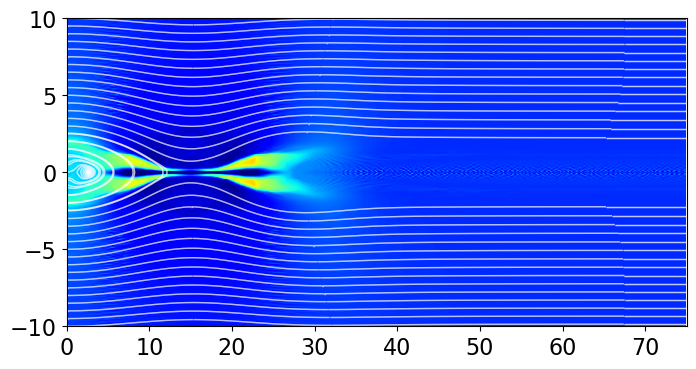

In [99]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

start_y = np.arange(-y_max, y_max, 0.5)
start_points = np.array([np.zeros(start_y.shape), start_y])

step = 22000

U = np.load(f"results_mr/U_{step}.npy")
rho = U[0, :, :]
u = U[1, :, :] / rho 
v = U[2, :, :] / rho 
w = U[3, :, :] / rho 
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
pT = p + magnetic_pressure

contour = ax1.pcolormesh(X, Y, (rho).T, vmin=0.8, vmax=2.0, cmap='jet')
if step == 0:
    cbar = plt.colorbar(contour, ax=ax1)
    cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)
quiver_interval = 5
ax1.streamplot(X, Y, Bx.T, By.T, broken_streamlines=False, 
            start_points=start_points.T, color='white', density = 50, linewidth=1, arrowsize=0)

#ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(0.0, x_max+1e-10)
ax1.set_ylim(-10, 10+1e-10)